In [1]:
import os
import json
import numpy as np
from scipy import signal, optimize
from scipy.spatial.transform import Rotation as R
import pandas as pd
# Pandas to display 3 decimal points
pd.options.display.float_format = '{:.3f}'.format
import matplotlib.pyplot as plt

import tools

# Make matplotlib interractive in jupyter
%matplotlib widget

In [2]:
def plot_est(state_df, sample_rate, title):
    t = np.arange(len(state_df))/sample_rate
    # Plot the estimated locations, and angles over time, with time axis in seconds, in 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
    fig.suptitle(title)
    ax1.plot(t, state_df['x_w'], 'r', label='x')
    ax1.plot(t, state_df['y_w'], 'g', label='y')
    ax1.plot(t, state_df['z_w'], 'b', label='z')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Location (m)')
    ax2.plot(t, state_df['pi_w']/(2*np.pi)*360, 'r', label='pitch')
    ax2.plot(t, state_df['ro_w']/(2*np.pi)*360, 'g', label='roll')
    ax2.plot(t, state_df['ya_w']/(2*np.pi)*360, 'b', label='yaw')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angle (deg)')
    plt.tight_layout()
    plt.show()


def run_location_tests(accelerometer, gyroscope, sample_rate, trackers: dict, plot_distance=True, plot_time=False):
    for i in range(len(accelerometer)):
        for tracker_name in trackers:
            trackers[tracker_name].add_measurement(accelerometer[i], gyroscope[i])

    df_list = [trackers[tracker_name].get_state_history_df() for tracker_name in trackers]
    # Print final locations
    # for tracker_name, df in zip(trackers, df_list):
    #     print(f'{tracker_name} Final Location: {df.iloc[-1]["x_w"]:0.3f}, {df.iloc[-1]["y_w"]:0.3f}, {df.iloc[-1]["z_w"]:0.3f}')

    if plot_distance:
        # Plot the estimated locations over time, with time axis in seconds
        plt.figure()
        for tracker_name, df in zip(trackers, df_list):
            plt.plot(df['x_w'].to_numpy(), df['y_w'].to_numpy(), label=tracker_name)
        plt.legend(loc='upper left')
        plt.xlabel('x position (m)')
        plt.ylabel('y position (m)')
        plt.tight_layout()
        plt.show()

    if plot_time:
        for tracker_name, df in zip(trackers, df_list):
            plot_est(df, sample_rate, tracker_name)

def test_file(file, calibration, plot_time=False, plot_distance=False, plot_data=False, settle_time=3):
    # TODO Change temperature to be taken into account on a sample-by-sample basis
    accelerometer, gyroscope, sample_rate, temperature, temperature_sample_rate = tools.read_data_file(
        os.path.join('..', 'tmp', file), lowpass=150, settle_time=settle_time
    )
    # Implement calibration
    accelerometer = accelerometer*np.array(calibration['accelerometer_sensitivity']) - np.array(calibration['accelerometer_offset'])
    gyroscope = gyroscope - np.array(calibration['gyroscope_offset']) - np.array(calibration['gyroscope_temperature_slope']) * np.mean(temperature)

    # Get initial rotation
    init_r = tools.Location3d.initial_rotation_from_accelerometer(accelerometer, sample_rate, length=0.25)

    if plot_data:
        tools.plot_data(accelerometer, gyroscope, sample_rate, f'{os.path.basename(file)}', temperature, temperature_sample_rate)
        tools.plot_data(init_r.apply(accelerometer), gyroscope, sample_rate, f'Rotated: {os.path.basename(file)}', temperature, temperature_sample_rate)

    # Process noise covariance (Too slow to react? Increase Q; Too sensitive to noise? Decrease the Q)
    config = tools.UkfConfig(
        state_n=len(tools.Location3d.state_names), measurement_n=6,
        alpha=1e-3, beta=2, kappa=0,
        Q=1e-4, P=1e-6, R=np.array(calibration['R']),
        init_r=init_r
    )
    # ukf_obj = tools.Location3dUkf(sample_rate=sample_rate, config=config)
    dr_obj = tools.Location3d(sample_rate=sample_rate, init_r=init_r)
    # dr_obj = tools.Location3d(sample_rate=sample_rate, init_r=init_r.inv())

    run_location_tests(
        # accelerometer, gyroscope, sample_rate, {'ukf': ukf_obj, 'dr': dr_obj}, plot_time=True
        accelerometer, gyroscope, sample_rate, {'dr': dr_obj}, plot_time=plot_time, plot_distance=plot_distance,
    )
    dr_df = dr_obj.get_state_history_df()
    final_x = dr_df.iloc[-1]["x_w"]
    final_y = dr_df.iloc[-1]["y_w"]
    final_z = dr_df.iloc[-1]["z_w"]

    init_euler = init_r.as_euler('xyz', degrees=True)

    # Calculate the integral of the rotated accelerometer vector to get an ideal velocity and distance
    rotated_accelerometer = init_r.apply(accelerometer)
    velocity = np.cumsum(rotated_accelerometer - np.array([0, 0, tools.GRAVITY]), axis=0) / sample_rate
    distance = np.cumsum(velocity, axis=0) / sample_rate

    return {
        'file': os.path.basename(file),
        'temperature': np.mean(temperature),
        'init_pitch': init_euler[0],
        'init_roll': init_euler[1],
        'init_yaw': init_euler[2],
        'mag_a': np.mean(np.linalg.norm(accelerometer, axis=1)),
        'final_x': final_x,
        'final_y': final_y,
        'final_z': final_z,
        'distance': np.linalg.norm([final_x, final_y, final_z]),
        'distance_sum': np.linalg.norm(distance[-1]),
        'xy_distance': np.linalg.norm([final_x, final_y]),
        'xy_distance_sum': np.linalg.norm(distance[-1][0:2]),
    }

In [3]:
# Read calibration data
file = 'calibration.json'
with open(file) as f:
    calibration = json.load(f)

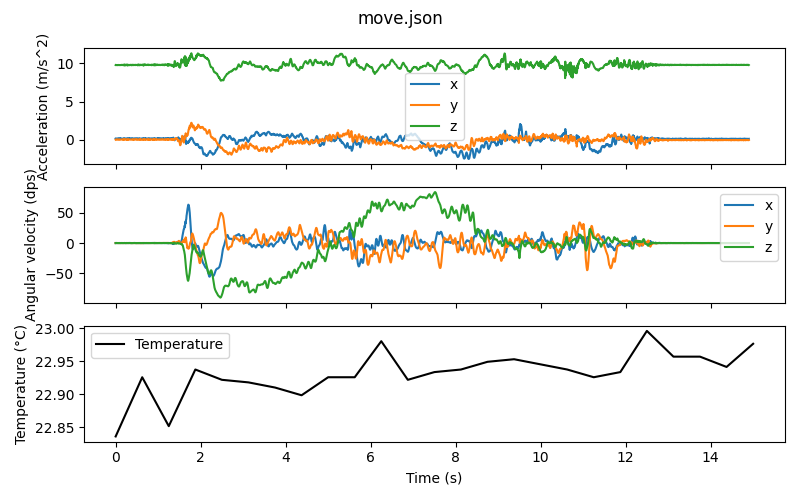

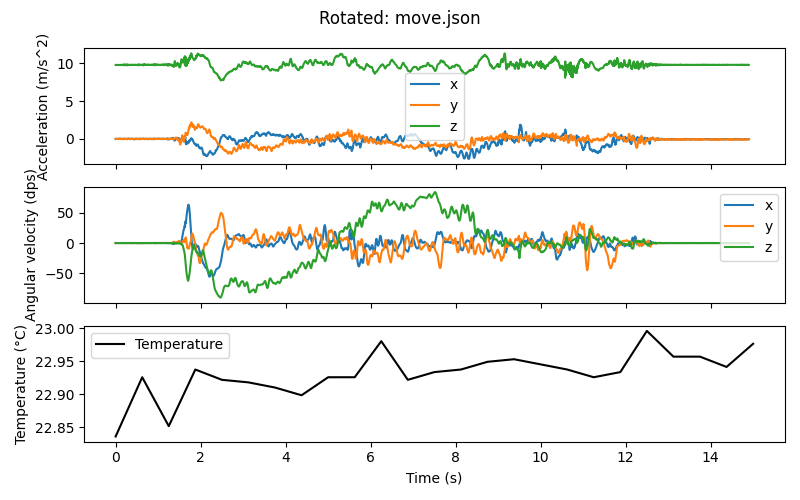

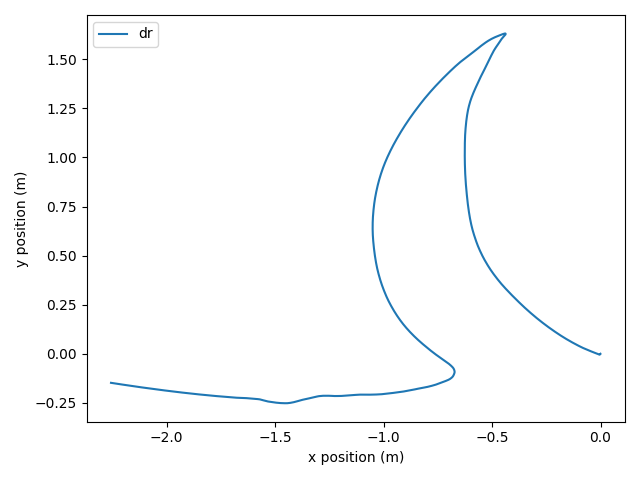

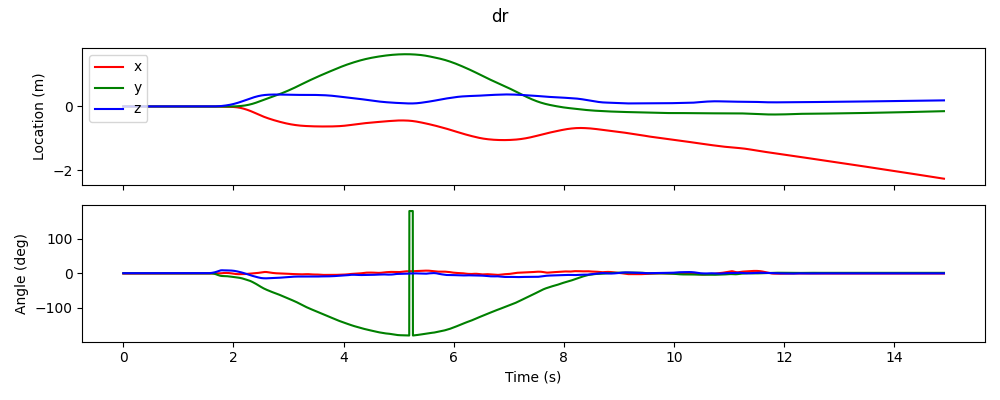

{'file': 'move.json',
 'temperature': 22.931875,
 'init_pitch': 0.19334571250136542,
 'init_roll': -0.9177116949503212,
 'init_yaw': -0.003096715145132755,
 'mag_a': 9.832623422126819,
 'final_x': -2.2569664420077977,
 'final_y': -0.1476926028726829,
 'final_z': 0.18949075957587672,
 'distance': 2.269717465513558,
 'distance_sum': 38.98873688943321,
 'xy_distance': 2.2617936743418143,
 'xy_distance_sum': 38.91316055326727}

In [4]:
test_file('test_5v/move.json', calibration, plot_time=True, plot_distance=True, plot_data=True, settle_time=0.1)
# test_file('cal_5v/cal_31.json', calibration, plot_time=True, plot_distance=True, plot_data=True)

In [5]:
cal_path = os.path.join('..', 'tmp', 'cal_5v')
# Get list of all JSON files in the path 
file_names = sorted([os.path.join(cal_path, f) for f in os.listdir(cal_path) if f.endswith('.json')])

df = []
for file in file_names:
    df.append(test_file(file, calibration))
df = pd.DataFrame(df)

temperature        1.000
init_pitch        -0.432
mag_a             -0.311
final_z           -0.298
init_roll          0.290
xy_distance_sum    0.248
final_x            0.226
final_y           -0.226
init_yaw          -0.219
xy_distance        0.134
distance_sum       0.048
distance           0.043
Name: temperature, dtype: float64

,file,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
0,cal_1.json,24.544,-179.804,-16.776,179.943,9.793,0.141,-0.065,-0.778,0.793,0.795,0.155,0.164
1,cal_10.json,23.953,0.316,13.162,0.072,9.779,0.085,-0.001,-1.698,1.700,1.699,0.085,0.060
2,cal_11.json,23.899,0.798,35.928,0.469,9.764,0.275,0.454,-2.868,2.917,2.872,0.531,0.154
3,cal_12.json,23.799,-0.590,-34.903,0.337,9.836,0.004,-0.062,2.389,2.390,2.390,0.062,0.085
4,cal_13.json,23.805,-1.655,-59.009,1.419,9.831,-0.051,0.152,1.959,1.966,1.961,0.160,0.071
5,cal_14.json,22.710,-5.842,0.105,-0.011,9.809,0.111,0.077,0.368,0.392,0.379,0.135,0.091
6,cal_15.json,22.830,-17.313,0.151,-0.047,9.814,-0.130,-0.139,0.764,0.787,0.777,0.190,0.144
7,cal_16.json,22.963,-29.181,0.101,-0.056,9.822,0.059,-0.133,1.390,1.398,1.405,0.145,0.200
8,cal_17.json,23.114,-45.793,0.424,-0.436,9.824,-0.200,0.067,1.511,1.525,1.514,0.211,0.102
9,cal_18.json,23.450,-65.885,0.681,-1.520,9.820,0.011,-0.005,0.093,0.094,0.093,0.012,0.005


,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
count,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000
mean,24.110,-5.010,1.745,37.803,9.803,-0.037,-0.034,-0.030,1.130,1.118,0.187,0.124
std,0.881,110.534,27.059,114.206,0.019,0.153,0.162,1.340,0.729,0.730,0.129,0.097
min,22.710,-179.804,-68.218,-179.939,9.764,-0.324,-0.474,-2.868,0.094,0.093,0.012,0.005
25%,23.450,-96.215,-0.606,-0.363,9.793,-0.130,-0.116,-0.737,0.496,0.599,0.086,0.068
50%,24.033,-0.528,0.101,0.038,9.801,-0.035,-0.015,-0.101,0.965,0.920,0.155,0.102
75%,24.512,45.968,8.588,179.362,9.820,0.084,0.022,0.934,1.610,1.638,0.277,0.164
max,25.906,179.689,64.587,179.967,9.836,0.275,0.454,2.389,2.917,2.872,0.531,0.484


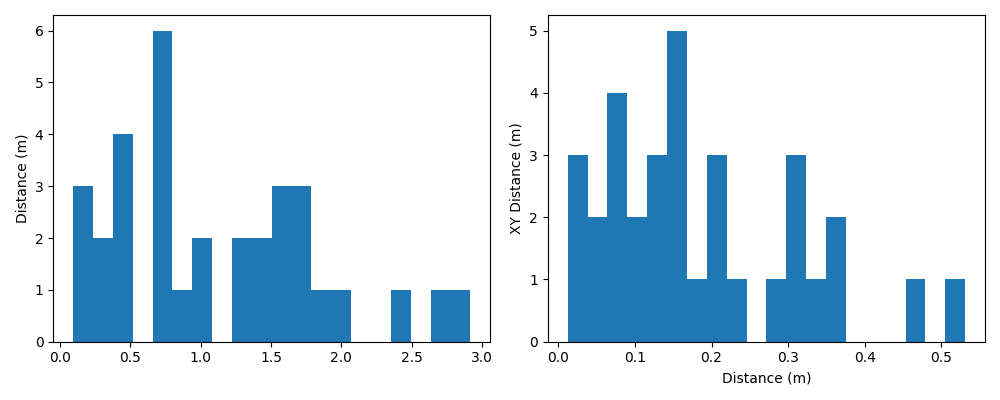

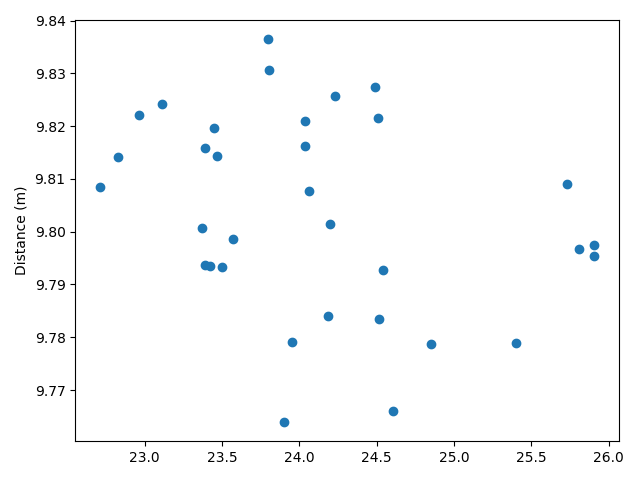

In [6]:
# Get the cross correlation for temperature in the dataframe
corr = df.drop(columns=['file']).corr()
# Display sorted by absolute value
display(corr['temperature'].sort_values(key=lambda x: np.abs(x), ascending=False))

display(df)
display(df.describe())

# Display a historgram of the distance and the xy_distance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(df['distance'], bins=20)
ax1.set_ylabel('Distance (m)')
ax2.hist(df['xy_distance'], bins=20)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('XY Distance (m)')
plt.tight_layout()
plt.show()

# Display distance vs temperature
plt.figure()
plt.plot(df['temperature'], df['mag_a'], 'o')
# plt.xlabel('Temperature (C)')
plt.ylabel('Distance (m)')
plt.tight_layout()
plt.show()

In [7]:
cal_path = os.path.join('..', 'tmp', 'test_5v')
# Get list of all JSON files in the path 
file_names = sorted([os.path.join(cal_path, f) for f in os.listdir(cal_path) if f.endswith('.json')])

test_df = []
for file in file_names:
    test_df.append(test_file(file, calibration))
test_df = pd.DataFrame(test_df)
display(test_df)

,file,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
0,move.json,22.940,-5.280,0.094,-0.009,9.833,21.059,-82.974,-4.791,85.739,43.548,85.605,43.501
1,static_table.json,23.718,-0.081,1.459,-0.002,9.794,-0.657,0.682,-3.491,3.618,3.501,0.947,0.269
2,table_test.json,21.261,0.166,0.030,0.000,9.800,3.164,2.078,-1.079,3.936,1.163,3.785,0.441
